In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
# import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
!pip install keras==3.3.3

In [ ]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

In [ ]:
!pip install -q kaggle

In [ ]:
os.getcwd()

'/content'

In [ ]:
os.chdir('/content/sample_data')

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
human-emotions-datasethes.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip "/content/sample_data/human-emotions-datasethes.zip" -d "/content/dataset/"

Archive:  /content/sample_data/human-emotions-datasethes.zip
replace /content/dataset/Emotions Dataset/Emotions Dataset/test/angry/101071.jpg_rotation_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 5,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION['CLASS_NAMES'],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99
)

Found 6799 files belonging to 3 classes.


In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

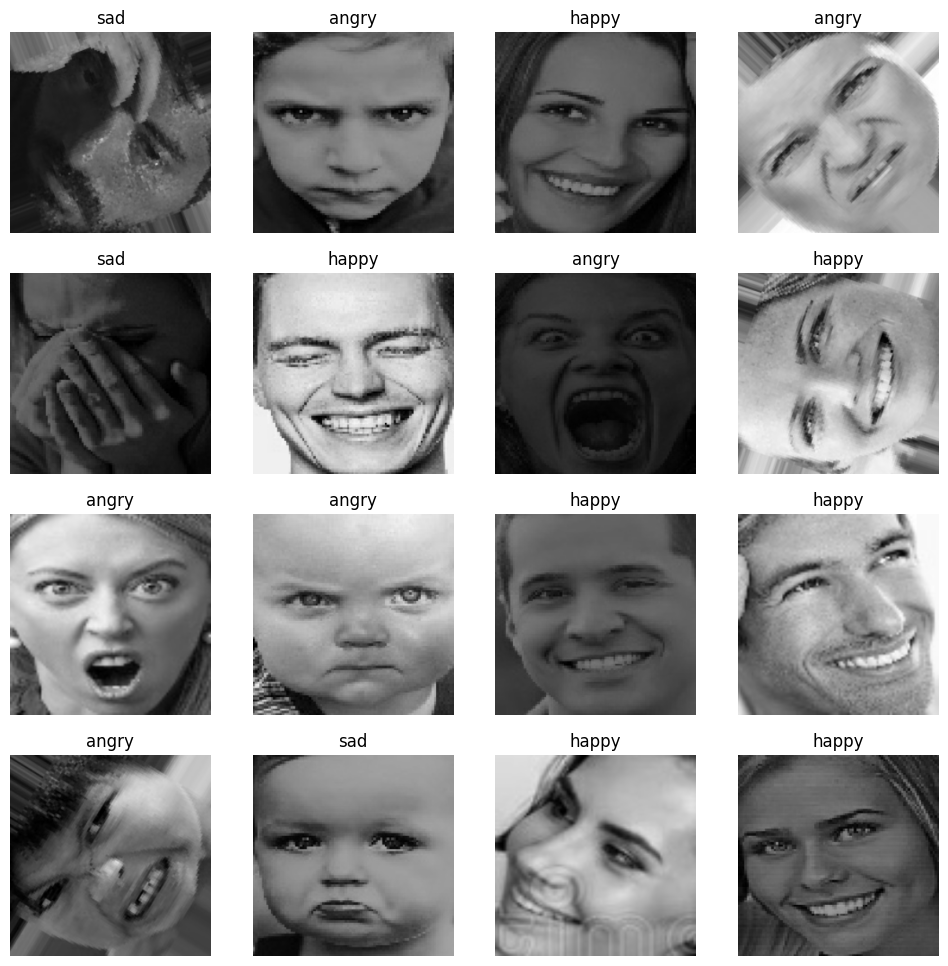

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

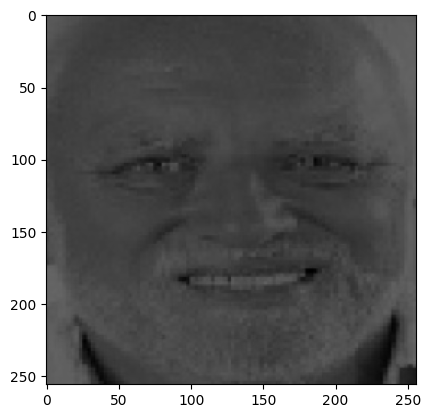

In [ ]:
plt.imshow(list(train_dataset.take(1).as_numpy_iterator())[0][0][3]/255.)

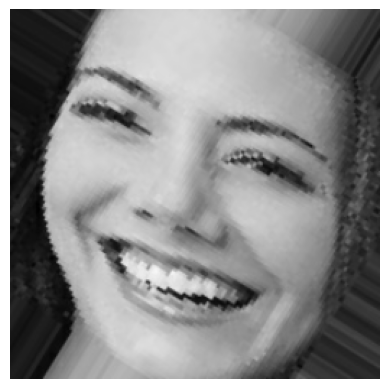

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Fetch the image data
image_array = list(train_dataset.take(1).as_numpy_iterator())[0][0][2]

# Normalize if necessary
if image_array.max() > 1:
    image_array = image_array / 255.0

# Display the image
plt.imshow(image_array)
plt.axis('off')  # Optional: Hide the axis
plt.show()


In [ ]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=1,#CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [ ]:
# # CONFIGURATION["CLASS_NAMES"]
# [tf.argmax(labels[i], axis = 0).numpy()]
# # CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()]
# # labels[18]
# # tf.argmax(labels[1])
# print(labels[18])
# tf.argmax(labels[18],axis=0).numpy()

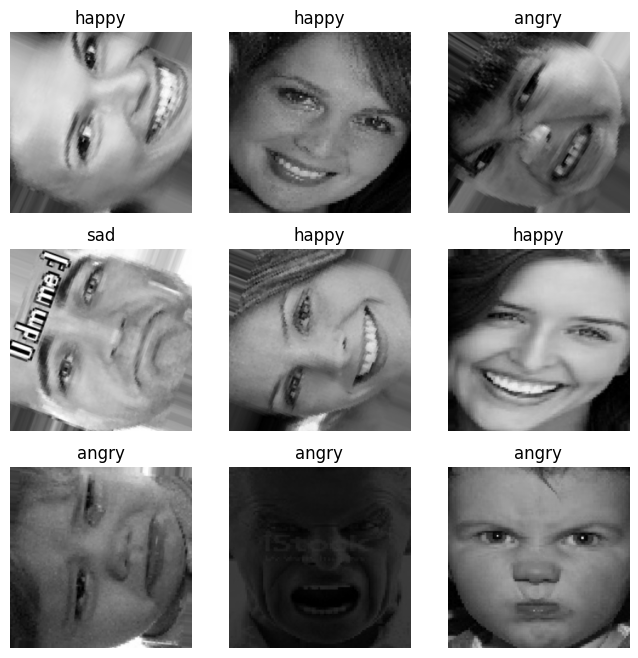

In [ ]:
plt.figure(figsize = (8,8))

for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

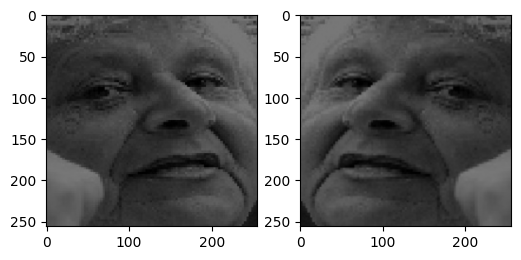

In [ ]:
### tf.keras.layer augment
augment_layers = tf.keras.Sequential([
  RandomRotation(factor=(-0.025, 0.025)),
  RandomFlip(mode='horizontal'),
  RandomContrast(factor=0.007),
])

# example of augmentation
plt.figure(figsize = (6,6))

image_array=list(train_dataset.take(1).as_numpy_iterator())[0][0][3]/255.
plt.subplot(1,2, 1)
plt.imshow(image_array)
plt.subplot(1,2, 2)
plt.imshow(augment_layers(image_array))

In [ ]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=1,#CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [ ]:
train_dataset=train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset=val_dataset.prefetch(tf.data.AUTOTUNE)


In [ ]:
print(train_dataset)
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
       Rescaling(1./255),
])

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )
backbone.trainable=False

In [ ]:
pretrained_model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

    ])
pretrained_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)          │ (None, 8, 8, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │       1,836,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,645,538 (74.94 MB)

 Trainable params: 1,969,667 (7.51 MB)

 Non-trainable params: 17,675,871 (67.43 MB)

In [ ]:
loss_function=CategoricalCrossentropy()
metrics=[CategoricalAccuracy(name="accuracy"), TopKCategoricalAccuracy(k=2, name='top_k_categorical_accuracy')]
pretrained_model.compile(optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
                    loss=loss_function, metrics=metrics)

In [ ]:
for layer in pretrained_model.layers:
    print(f"Layer: {layer.name}")

    try:
        # Use input/output tensor instead of input_shape/output_shape
        print(f"  Input: {layer.input}")
        print(f"  Output: {layer.output}")
    except AttributeError:
        # Some layers may not have input/output attributes before they are connected
        print(f"  Layer {layer.name} has no input/output attribute.")

    print("-" * 50)

Layer: efficientnetb4
  Input: <KerasTensor shape=(None, 256, 256, 3), dtype=float32, sparse=None, name=keras_tensor_4>
  Output: <KerasTensor shape=(None, 8, 8, 1792), dtype=float32, sparse=False, name=keras_tensor_478>
--------------------------------------------------
Layer: global_average_pooling2d
  Input: <KerasTensor shape=(None, 8, 8, 1792), dtype=float32, sparse=False, name=keras_tensor_480>
  Output: <KerasTensor shape=(None, 1792), dtype=float32, sparse=False, name=keras_tensor_481>
--------------------------------------------------
Layer: dense
  Input: <KerasTensor shape=(None, 1792), dtype=float32, sparse=False, name=keras_tensor_481>
  Output: <KerasTensor shape=(None, 1024), dtype=float32, sparse=False, name=keras_tensor_482>
--------------------------------------------------
Layer: batch_normalization
  Input: <KerasTensor shape=(None, 1024), dtype=float32, sparse=False, name=keras_tensor_482>
  Output: <KerasTensor shape=(None, 1024), dtype=float32, sparse=False, name

In [ ]:
### Basic Model fit
history=pretrained_model.fit(train_dataset, validation_data=val_dataset,epochs=5, verbose=1)

Epoch 1/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 402s 1s/step - accuracy: 0.6482 - loss: 1.0122 - top_k_categorical_accuracy: 0.8667 - val_accuracy: 0.3090 - val_loss: 4.7506 - val_top_k_categorical_accuracy: 0.7779
Epoch 2/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 117s 551ms/step - accuracy: 0.6795 - loss: 0.9835 - top_k_categorical_accuracy: 0.8899 - val_accuracy: 0.5474 - val_loss: 151.6770 - val_top_k_categorical_accuracy: 0.9100
Epoch 3/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.7431 - loss: 0.7407 - top_k_categorical_accuracy: 0.9233

KeyboardInterrupt: 

In [ ]:
pretrained_model

<Sequential name=sequential_2, built=True>

In [ ]:
### Basic Model fit
history=pretrained_model.fit(train_dataset.take(10), validation_data=val_dataset,epochs=6, verbose=1)

Epoch 1/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 148s 5s/step - accuracy: 0.4773 - loss: 1.7858 - top_k_categorical_accuracy: 0.7642 - val_accuracy: 0.6093 - val_loss: 0.8725 - val_top_k_categorical_accuracy: 0.8582
Epoch 2/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.7668 - loss: 0.7083 - top_k_categorical_accuracy: 0.9363 - val_accuracy: 0.4087 - val_loss: 1.1015 - val_top_k_categorical_accuracy: 0.8143
Epoch 3/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.8125 - loss: 0.5778 - top_k_categorical_accuracy: 0.9602 - val_accuracy: 0.6119 - val_loss: 0.8572 - val_top_k_categorical_accuracy: 0.8617
Epoch 4/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.8665 - loss: 0.4093 - top_k_categorical_accuracy: 0.9731 - val_accuracy: 0.6580 - val_loss: 0.7498 - val_top_k_categorical_accuracy: 0.8780
Epoch 5/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.8934 - loss: 0.2833 - top_k_categorical_accuracy: 0.9905 - val_accuracy: 0.6304 - val_loss: 0.8399 - val_top_k_categorical_a

In [ ]:
pretrained_model

<Sequential name=sequential_2, built=True>

In [ ]:
# Saving the model
pretrained_model.save('my_model.keras')

happy


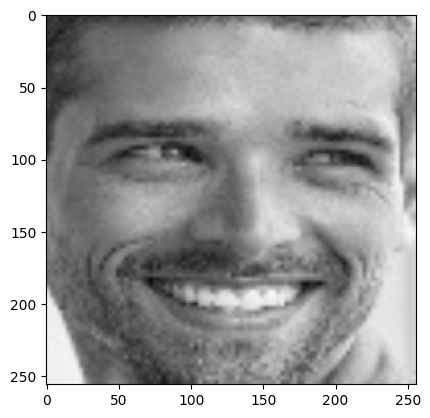

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/126093.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
plt.imshow(test_image)
im=tf.constant(test_image, dtype=tf.float32 )
im=tf.expand_dims(im, axis=0)
pretrained_model(im)

print(CONFIGURATION["CLASS_NAMES"][tf.argmax(pretrained_model(im), axis = -1).numpy()[0]])


In [ ]:
from tensorflow.keras.models import load_model

# Load the model from the .h5 file
model = load_model('my_model.keras')

In [ ]:
CONFIGURATION['CLASS_NAMES'][tf.argmax(model.predict(im), axis=-1).numpy()[0]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


'happy'

In [ ]:
from google.colab import files
files.download('file.txt')

In [ ]:
pretrained_model.evaluate(val_dataset)

2278/2278 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.6360 - loss: 0.8515 - top_k_categorical_accuracy: 0.8809


[0.8381080031394958, 0.6352063417434692, 0.8775241374969482]

In [ ]:
backbone.trainable = True

input = Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3))

# Note the training = False parameter. In finetuning we don't change these parameters and hence work in inference mode.
# These were already obtained during pretraining
x = backbone(input, training = False)
x = GlobalAveragePooling2D()(x)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

finetuned_model = Model(input, output)
finetuned_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb4 (Functional)          │ (None, 8, 8, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │       1,836,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,645,538 (74.94 MB)

 Trainable params: 19,518,283 (74.46 MB)

 Non-trainable params: 127,255 (497.09 KB)

In [ ]:
loss_function=CategoricalCrossentropy()
metrics=[CategoricalAccuracy(name="accuracy"), TopKCategoricalAccuracy(k=2, name='top_k_categorical_accuracy')]
finetuned_model.compile(optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']/100),
                    loss=loss_function, metrics=metrics)

In [ ]:
history=finetuned_model.fit(train_dataset, validation_data=val_dataset,epochs=6, verbose=1)

Epoch 1/6
213/213 ━━━━━━━━━━━━━━━━━━━━ 117s 547ms/step - accuracy: 0.8009 - loss: 0.4866 - top_k_categorical_accuracy: 0.9478 - val_accuracy: 0.7546 - val_loss: 0.5956 - val_top_k_categorical_accuracy: 0.9223
Epoch 2/6
213/213 ━━━━━━━━━━━━━━━━━━━━ 134s 629ms/step - accuracy: 0.8316 - loss: 0.4287 - top_k_categorical_accuracy: 0.9537 - val_accuracy: 0.7665 - val_loss: 0.5679 - val_top_k_categorical_accuracy: 0.9267
Epoch 3/6
213/213 ━━━━━━━━━━━━━━━━━━━━ 125s 549ms/step - accuracy: 0.8545 - loss: 0.3754 - top_k_categorical_accuracy: 0.9683 - val_accuracy: 0.7748 - val_loss: 0.5545 - val_top_k_categorical_accuracy: 0.9284
Epoch 4/6
213/213 ━━━━━━━━━━━━━━━━━━━━ 141s 546ms/step - accuracy: 0.8670 - loss: 0.3439 - top_k_categorical_accuracy: 0.9666 - val_accuracy: 0.7893 - val_loss: 0.5355 - val_top_k_categorical_accuracy: 0.9324
Epoch 5/6
213/213 ━━━━━━━━━━━━━━━━━━━━ 116s 544ms/step - accuracy: 0.8847 - loss: 0.3069 - top_k_categorical_accuracy: 0.9798 - val_accuracy: 0.7985 - val_loss: 0.5

In [ ]:
# Saving the model
finetuned_model.save('my_model1.keras')

In [ ]:
from google.colab import files

files.download('/content/sample_data/my_model1.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>